In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
file_path = '/content/drive/MyDrive/EGT309 AI solution development project/master_dataset.csv'
df = pd.read_csv(file_path)

Mounted at /content/drive


###Data preprocessing, Feature engineering and selection

In [ ]:
print(df.isnull().sum())

order_id                            0
order_status                        0
order_purchase_timestamp            0
order_delivered_customer_date       0
customer_unique_id                  0
zip_code                            0
city                                0
state                               0
product_id                          0
seller_id                           0
price                               0
payment_type                        0
payment_installments                0
payment_value                       0
review_score                      722
product_category_name_english    1486
dtype: int64


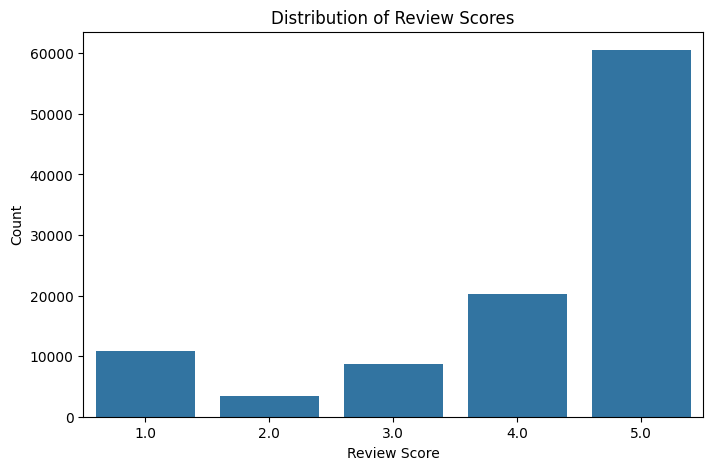

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.countplot(x='review_score', data=df)
plt.title('Distribution of Review Scores')
plt.xlabel('Review Score')
plt.ylabel('Count')
plt.show()

In [ ]:
# Find the mode (most common value) for review_score
mode_value = df['review_score'].mode()[0]
# Fill missing values with the mode
df['review_score'] = df['review_score'].fillna(mode_value)

In [ ]:
missing_cat = df[df['product_category_name_english'].isnull()]
print(missing_cat[['order_id', 'product_id', 'product_category_name_english']].head(10))

                             order_id                        product_id  \
113  bfe42c22ecbf90bc9f35cf591270b6a7  71225f49be70df4297892f6a5fa62171   
191  58ac1947c1a9067b9f416cba6d844a3f  9820e04e332fc450d6fd975befc1bc28   
241  e22b71f6e4a481445ec4527cb4c405f7  3bc5164bc7f4be77002d6651da65c98c   
278  a094215e786240fcfefb83d18036a1cd  5a848e4ab52fd5445cdc07aab1c40e48   
347  6f841dde94727854eaff3f66432c80ea  c600d7f13104e8db2ca2b9fa78581409   
489  66cf92fc3ec94fbafc4edd77e0814818  de6702c748c719cbd13bb814f006ba22   
546  769cad60df1d40dccfd5ec163be24654  26a4f62a409a78816adb31e0d729a163   
707  14d68c5b215a31950340dc9cb3f73efe  5a848e4ab52fd5445cdc07aab1c40e48   
736  1b99333d39cf95f48be3864b2e1e88b3  0ae10ca52e6cb8745e17c11e7c43907c   
963  8dbdb81783a3c754dc9441826510a36a  1954739d84629e7323a4295812a3e0ec   

    product_category_name_english  
113                           NaN  
191                           NaN  
241                           NaN  
278                           

In [ ]:
# Drop rows where product_category_name_english is missing (NaN)
df = df.dropna(subset=['product_category_name_english'])
df = df.reset_index(drop=True)

In [ ]:
print(df.isnull().sum())

order_id                         0
order_status                     0
order_purchase_timestamp         0
order_delivered_customer_date    0
customer_unique_id               0
zip_code                         0
city                             0
state                            0
product_id                       0
seller_id                        0
price                            0
payment_type                     0
payment_installments             0
payment_value                    0
review_score                     0
product_category_name_english    0
dtype: int64


In [ ]:
# Check for duplicate rows
print("Duplicate rows:", df.duplicated().sum())

Duplicate rows: 0


In [ ]:
# # Save the cleaned DataFrame to CSV
# df.to_csv('/content/drive/MyDrive/EGT309 AI solution development project/cleaned_master_dataset_.csv', index=False)

In [ ]:
# 1. Compute customer frequency for repeat buyer target
customer_orders = df.groupby('customer_unique_id')['order_id'].nunique().reset_index()
customer_orders.columns = ['customer_unique_id', 'order_count']

In [ ]:
# 2. Merge back and create the target column
df = pd.merge(df, customer_orders, on='customer_unique_id', how='left')
df['is_repeat_buyer'] = df['order_count'].apply(lambda x: 1 if x > 1 else 0)

In [ ]:
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
last_purchase = df.groupby('customer_unique_id')['order_purchase_timestamp'].max().reset_index()
now = df['order_purchase_timestamp'].max()
last_purchase['recency_days'] = (now - last_purchase['order_purchase_timestamp']).dt.days
df = pd.merge(df, last_purchase[['customer_unique_id', 'recency_days']], on='customer_unique_id', how='left')

In [ ]:
df['purchase_month'] = df['order_purchase_timestamp'].dt.month
df['purchase_dayofweek'] = df['order_purchase_timestamp'].dt.dayofweek

In [ ]:
df.dtypes

,0
order_id,object
order_status,object
order_purchase_timestamp,datetime64[ns]
order_delivered_customer_date,object
customer_unique_id,object
zip_code,int64
city,object
state,object
product_id,object
seller_id,object


In [ ]:
for col in ['product_category_name_english', 'payment_type', 'city', 'state']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

In [ ]:
# 3. Select features for ML (now include new features)
features = [
    'price',
    'payment_type',
    'payment_installments',
    'payment_value',
    'review_score',
    'product_category_name_english',
    'zip_code',
    'city',
    'state',
    'recency_days',
    'purchase_month',
    'purchase_dayofweek'
]
X = df[features]
y = df['is_repeat_buyer']

In [ ]:
# 6. Save processed features for future use if needed
# X.to_csv('/content/drive/MyDrive/EGT309 Project/prepared_ml_features.csv', index=False)
# y.to_csv('/content/drive/MyDrive/EGT309 Project/prepared_ml_target.csv', index=False)

In [ ]:
df.head()

,order_id,order_status,order_purchase_timestamp,order_delivered_customer_date,customer_unique_id,zip_code,city,state,product_id,seller_id,...,payment_type,payment_installments,payment_value,review_score,product_category_name_english,order_count,is_repeat_buyer,recency_days,purchase_month,purchase_dayofweek
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,7c396fd4830fd04220f754e42b4e5bff,3149,3554,25,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,...,1,1.0,18.12,4.0,49,2,1,331,10,0
1,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,7c396fd4830fd04220f754e42b4e5bff,3149,3554,25,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,...,4,1.0,2.00,4.0,49,2,1,331,10,0
2,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,7c396fd4830fd04220f754e42b4e5bff,3149,3554,25,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,...,4,1.0,18.59,4.0,49,2,1,331,10,0
3,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,2018-08-07 15:27:45,af07308b275d755c9edb36a90c618231,47813,413,4,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,...,0,1.0,141.46,4.0,59,1,0,35,7,1
4,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,2018-08-17 18:06:29,3a653a41f6f9fc3d2a113cf8398680e8,75265,4005,8,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,...,1,3.0,179.12,5.0,5,1,0,21,8,2


In [ ]:
df.dtypes

,0
order_id,object
order_status,object
order_purchase_timestamp,datetime64[ns]
order_delivered_customer_date,object
customer_unique_id,object
zip_code,int64
city,int64
state,int64
product_id,object
seller_id,object


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=True)

###Initial Model Training

In [ ]:
clf = RandomForestClassifier()   #with default parameters

clf.fit(X_train,y_train)
acc = clf.score(X_test,y_test)
print('Accuracy:', acc)
print('Number of trees:', clf.n_estimators)

Accuracy: 0.9475731932691372
Number of trees: 100


In [ ]:
y_train_pred =  clf.predict(X_train)
y_train_pred_prob =  clf.predict_proba(X_train)

In [ ]:
y_train_pred

array([0, 0, 0, ..., 1, 0, 0])

In [ ]:
y_train_pred_prob

array([[1.  , 0.  ],
       [0.99, 0.01],
       [0.98, 0.02],
       ...,
       [0.16, 0.84],
       [0.98, 0.02],
       [0.99, 0.01]])

<Axes: xlabel='predict', ylabel='actual'>

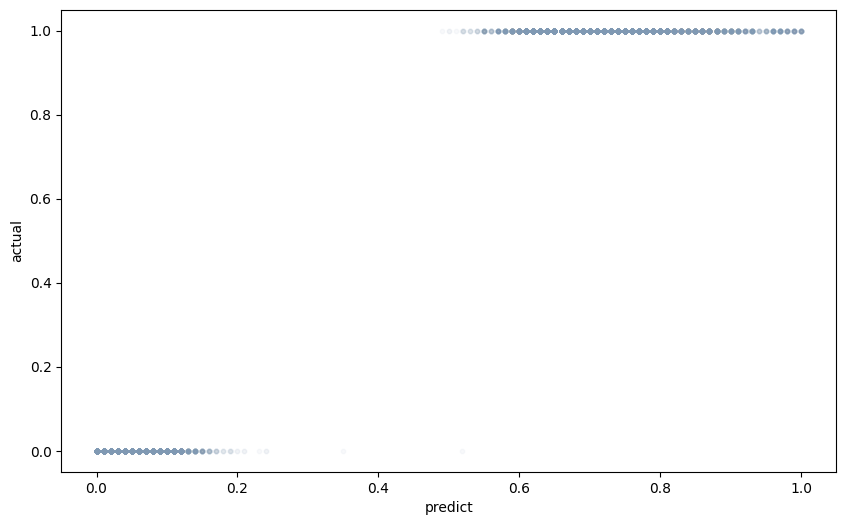

In [ ]:
#Training Distribution map
y_train = y_train.replace(True, 1).replace(False, 0).astype(np.int64)
y_train_scores = y_train_pred_prob[:, 1]
train_predict = pd.DataFrame({'actual': y_train.values,
                              'predict': y_train_scores})
# train_predict
color =np.array([0.5, 0.6, 0.7]).reshape(1,-1)

train_predict.plot.scatter(x='predict', y='actual', s=10, alpha=0.05, figsize=(10,6), c= color)

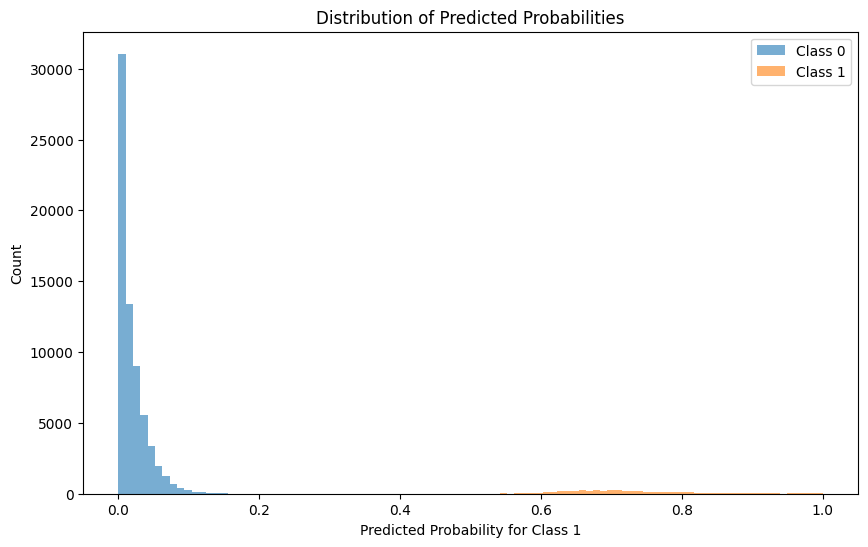

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.hist(y_train_scores[y_train==0], bins=50, alpha=0.6, label='Class 0')
plt.hist(y_train_scores[y_train==1], bins=50, alpha=0.6, label='Class 1')
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability for Class 1')
plt.ylabel('Count')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train, y_train_scores)

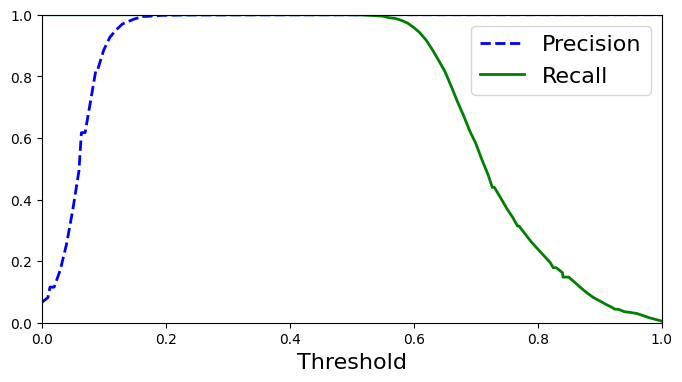

In [ ]:
def plot_precision_recall_curve(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper right", fontsize=16)
    plt.xlim([0, 1])
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_curve(precisions, recalls, thresholds)
plt.show()

In [ ]:
threshold = 0.2  # Or any value from your plot
y_pred_custom = (y_train_scores > threshold).astype(int)
print(classification_report(y_train, y_pred_custom))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     67243
           1       1.00      1.00      1.00      4723

    accuracy                           1.00     71966
   macro avg       1.00      1.00      1.00     71966
weighted avg       1.00      1.00      1.00     71966



#Trying on test set

In [ ]:
y_test_pred_prob = clf.predict_proba(X_test)
y_test_pred_prob

array([[0.94, 0.06],
       [0.89, 0.11],
       [1.  , 0.  ],
       ...,
       [0.99, 0.01],
       [0.8 , 0.2 ],
       [0.93, 0.07]])

In [ ]:
y_test_scores = y_test_pred_prob[:, 1]
y_test_scores

array([0.06, 0.11, 0.  , ..., 0.01, 0.2 , 0.07])

In [ ]:
threshold = 0.2
y_pred_test_custom = (y_test_scores > threshold).astype(int)

# Print the classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_test_custom))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     28847
           1       0.68      0.47      0.56      1996

    accuracy                           0.95     30843
   macro avg       0.82      0.73      0.77     30843
weighted avg       0.95      0.95      0.95     30843



#Find best threshold

In [ ]:
from sklearn.metrics import precision_recall_curve, f1_score
import numpy as np

# Get predicted probabilities for class 1
y_test_scores = clf.predict_proba(X_test)[:, 1]

# Calculate precision, recall, and thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_test_scores)

# Compute F1 for each threshold
f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)

# Exclude last value (thresholds is len-1 of precisions/recalls)
best_idx = np.argmax(f1s[:-1])
best_threshold = thresholds[best_idx]
best_f1 = f1s[best_idx]

print(f"Best threshold for F1: {best_threshold:.3f}")
print(f"Best F1 score: {best_f1:.3f}")

# Predict using the best threshold
y_pred_best_thresh = (y_test_scores > best_threshold).astype(int)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_best_thresh))

Best threshold for F1: 0.220
Best F1 score: 0.562
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     28847
           1       0.75      0.45      0.56      1996

    accuracy                           0.95     30843
   macro avg       0.85      0.72      0.77     30843
weighted avg       0.95      0.95      0.95     30843



In [ ]:
for t in np.arange(0.1, 0.5, 0.05):
    y_pred = (y_test_scores > t).astype(int)
    report = classification_report(y_test, y_pred, output_dict=True)
    print(f"Threshold: {t:.2f}, Recall for class 1: {report['1']['recall']:.3f}, Precision: {report['1']['precision']:.3f}, F1: {report['1']['f1-score']:.3f}")

Threshold: 0.10, Recall for class 1: 0.677, Precision: 0.242, F1: 0.357
Threshold: 0.15, Recall for class 1: 0.562, Precision: 0.444, F1: 0.496
Threshold: 0.20, Recall for class 1: 0.475, Precision: 0.676, F1: 0.558
Threshold: 0.25, Recall for class 1: 0.402, Precision: 0.836, F1: 0.543
Threshold: 0.30, Recall for class 1: 0.351, Precision: 0.923, F1: 0.508
Threshold: 0.35, Recall for class 1: 0.308, Precision: 0.958, F1: 0.466
Threshold: 0.40, Recall for class 1: 0.264, Precision: 0.978, F1: 0.415
Threshold: 0.45, Recall for class 1: 0.219, Precision: 0.991, F1: 0.359


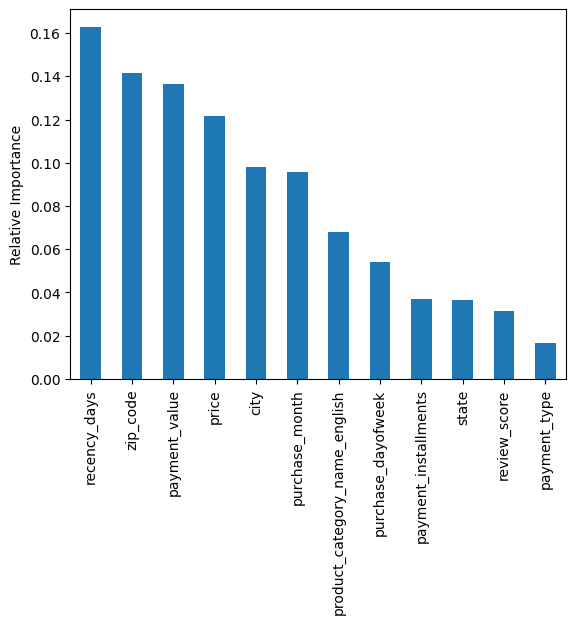

In [ ]:
#feature importance
feature_imp = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
fig = plt.figure()
ax = feature_imp.plot(kind='bar')
ax.set(ylabel='Relative Importance');

##Fine-tuning Hyperparameters

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth': [20,30,40],
    'min_samples_split': [2, 5, 8],
    'min_samples_leaf': [2, 4, 6],
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
grid = GridSearchCV(
    rf,
    param_grid,
    scoring='f1',
    cv=2,
    verbose=2,
    n_jobs=-1
)
grid.fit(X_train, y_train)
print("Best parameters:", grid.best_params_)
print("Best F1 score:", grid.best_score_)

Fitting 2 folds for each of 81 candidates, totalling 162 fits
Best parameters: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Best F1 score: 0.04260788786757459


In [ ]:
train_pred = grid.predict(X_train)
test_pred = grid.predict(X_test)

from sklearn.metrics import f1_score

print("Training F1:", f1_score(y_train, train_pred, pos_label=1))
print("Test F1:", f1_score(y_test, test_pred, pos_label=1))

Training F1: 0.15822291504286828
Test F1: 0.06298449612403101


In [ ]:
for depth in [10, 15, 20]:
    for leaf in [2, 4, 8]:
        clf2 = RandomForestClassifier(
            n_estimators=100,
            max_depth=depth,
            min_samples_leaf=leaf,
            min_samples_split=2,
            random_state=42
        )
        clf2.fit(X_train, y_train)
        train_f1 = f1_score(y_train, clf2.predict(X_train), pos_label=1)
        test_f1 = f1_score(y_test, clf2.predict(X_test), pos_label=1)
        print(f"Depth: {depth}, Min leaf: {leaf} --> Train F1: {train_f1:.3f}, Test F1: {test_f1:.3f}")


Depth: 10, Min leaf: 2 --> Train F1: 0.028, Test F1: 0.011
Depth: 10, Min leaf: 4 --> Train F1: 0.025, Test F1: 0.012
Depth: 10, Min leaf: 8 --> Train F1: 0.018, Test F1: 0.005
Depth: 15, Min leaf: 2 --> Train F1: 0.158, Test F1: 0.064
Depth: 15, Min leaf: 4 --> Train F1: 0.093, Test F1: 0.038
Depth: 15, Min leaf: 8 --> Train F1: 0.054, Test F1: 0.026
Depth: 20, Min leaf: 2 --> Train F1: 0.365, Test F1: 0.124
Depth: 20, Min leaf: 4 --> Train F1: 0.198, Test F1: 0.073
Depth: 20, Min leaf: 8 --> Train F1: 0.084, Test F1: 0.040


In [ ]:
y_proba = clf2.predict_proba(X_test)[:, 1]
y_pred_thresh = (y_proba > 0.2).astype(int)
print(f1_score(y_test, y_pred_thresh, pos_label=1))


0.3561859732072498


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

# Use your best engineered features in X_train, X_test

param_grid = {
    'n_estimators': [500, 700, 900],
    'max_depth': [20,25,30],
    'min_samples_leaf': [7,10],
    'min_samples_split': [7,10],
    'max_features': ['sqrt'],
}

rf = RandomForestClassifier(class_weight = 'balanced' , random_state=42, n_jobs=-1)
grid1 = GridSearchCV(
    rf,
    param_grid,
    scoring='recall',
    cv=5,
    verbose=2,
    n_jobs=-1
)
grid1.fit(X_train, y_train)

print("Best parameters:", grid1.best_params_)
print("Best F1 score (CV):", grid1.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 7, 'n_estimators': 700}
Best F1 score (CV): 0.2187149134606762


In [ ]:
# Evaluate on test set
from sklearn.metrics import classification_report

y_test_pred_proba = grid1.best_estimator_.predict_proba(X_test)[:, 1]
best_thresh = 0.2   # Or use your best found threshold
y_test_pred = (y_test_pred_proba > best_thresh).astype(int)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.98      0.26      0.41     28847
           1       0.08      0.93      0.15      1996

    accuracy                           0.30     30843
   macro avg       0.53      0.60      0.28     30843
weighted avg       0.92      0.30      0.39     30843



#LightGBM

In [ ]:
print(X.dtypes)

price                            float64
payment_type                       int64
payment_installments             float64
payment_value                    float64
review_score                     float64
product_category_name_english      int64
zip_code                           int64
city                               int64
state                              int64
recency_days                       int64
purchase_month                     int32
purchase_dayofweek                 int32
dtype: object


In [ ]:
import lightgbm as lgb
from sklearn.metrics import f1_score, classification_report

# Create and train the model
lgbm = lgb.LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

lgbm.fit(X_train, y_train)

# Predict probabilities for threshold tuning
y_proba = lgbm.predict_proba(X_test)[:, 1]

[LightGBM] [Info] Number of positive: 4723, number of negative: 67243
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1423
[LightGBM] [Info] Number of data points in the train set: 71966, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
F1-score: 0.1433558473097063
              precision    recall  f1-score   support

           0       0.98      0.22      0.36     28847
           1       0.08      0.95      0.14      1996

    accuracy                           0.27     30843
   macro avg       0.53      0.58      0.25     30843
weighted avg       0.92      0.27      0.35     30843



In [ ]:
# Try your best threshold (e.g., 0.2)
threshold = 0.6
y_pred_thresh = (y_proba > threshold).astype(int)

# Evaluate
print("F1-score:", f1_score(y_test, y_pred_thresh, pos_label=1))
print(classification_report(y_test, y_pred_thresh))

F1-score: 0.46601941747572817
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     28847
           1       0.50      0.43      0.47      1996

    accuracy                           0.94     30843
   macro avg       0.73      0.70      0.72     30843
weighted avg       0.93      0.94      0.93     30843



In [ ]:
y_test_scores = y_proba  # Probabilities for class 1

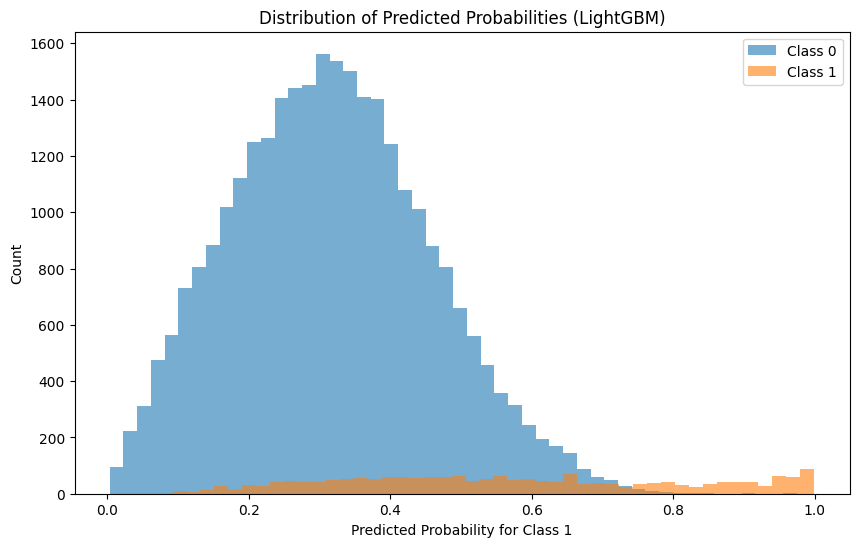

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.hist(y_test_scores[y_test == 0], bins=50, alpha=0.6, label='Class 0')
plt.hist(y_test_scores[y_test == 1], bins=50, alpha=0.6, label='Class 1')
plt.title('Distribution of Predicted Probabilities (LightGBM)')
plt.xlabel('Predicted Probability for Class 1')
plt.ylabel('Count')
plt.legend()
plt.show()

#Optimization

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
import numpy as np

# Calculate scale_pos_weight
scale_weight = (y_train == 0).sum() / (y_train == 1).sum()

param_grid = {
    'num_leaves': [7, 15, 31, 63, 127],
    'max_depth': [3, 5, 7, 10, 15],
    'min_child_samples': [5, 10, 20, 50, 100],
    'scale_pos_weight': [1, 3, 7, 10, int(scale_weight)],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [200, 400, 600],
    'class_weight': ['balanced']
}

lgbm = lgb.LGBMClassifier(
    random_state=42,
    n_jobs=-1
)

rs = RandomizedSearchCV(
    lgbm,
    param_distributions=param_grid,
    n_iter=30,          # Try more for thorough search
    scoring='f1',       # Or use make_scorer for class 1 only
    cv=3,
    verbose=2,
    n_jobs=-1
)

rs.fit(X_train, y_train)

print("Best params:", rs.best_params_)
print("Best CV F1:", rs.best_score_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[LightGBM] [Info] Number of positive: 4723, number of negative: 67243
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1423
[LightGBM] [Info] Number of data points in the train set: 71966, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [ ]:
from sklearn.metrics import classification_report, f1_score

# 1. Retrieve best model
best_lgbm = rs.best_estimator_

# 2. Predict probabilities for threshold tuning
y_train_proba = best_lgbm.predict_proba(X_train)[:, 1]
y_test_proba = best_lgbm.predict_proba(X_test)[:, 1]

In [ ]:
# 3. Choose your best threshold (start with 0.2 or sweep for optimal value)
threshold = 0.5

y_train_pred = (y_train_proba > threshold).astype(int)
y_test_pred = (y_test_proba > threshold).astype(int)

# 4. Print metrics for training set
print("=== TRAINING SET ===")
print(f"F1-score: {f1_score(y_train, y_train_pred, pos_label=1):.3f}")
print(classification_report(y_train, y_train_pred))

# 5. Print metrics for test set
print("=== TEST SET ===")
print(f"F1-score: {f1_score(y_test, y_test_pred, pos_label=1):.3f}")
print(classification_report(y_test, y_test_pred))

=== TRAINING SET ===
F1-score: 0.508
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     67243
           1       0.37      0.81      0.51      4723

    accuracy                           0.90     71966
   macro avg       0.68      0.86      0.73     71966
weighted avg       0.95      0.90      0.91     71966

=== TEST SET ===
F1-score: 0.353
              precision    recall  f1-score   support

           0       0.97      0.89      0.92     28847
           1       0.26      0.57      0.35      1996

    accuracy                           0.87     30843
   macro avg       0.61      0.73      0.64     30843
weighted avg       0.92      0.87      0.89     30843



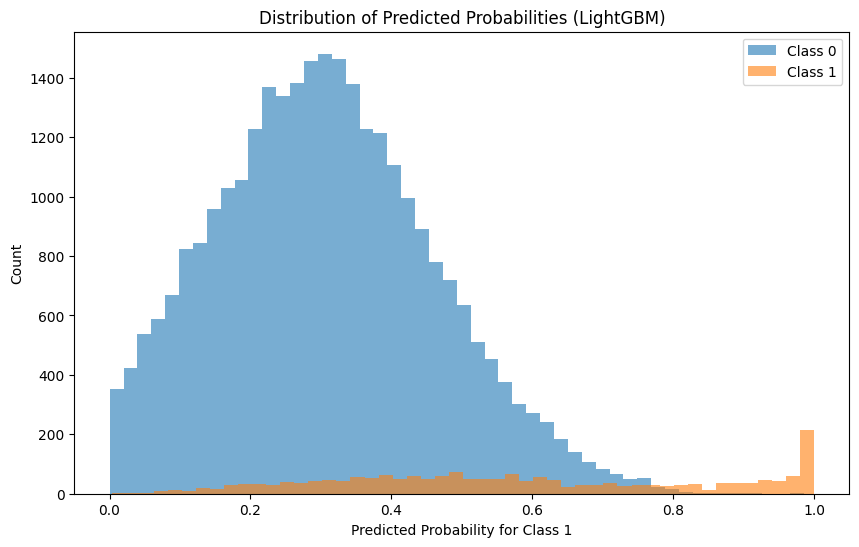

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.hist(y_test_proba[y_test == 0], bins=50, alpha=0.6, label='Class 0')
plt.hist(y_test_proba[y_test == 1], bins=50, alpha=0.6, label='Class 1')
plt.title('Distribution of Predicted Probabilities (LightGBM)')
plt.xlabel('Predicted Probability for Class 1')
plt.ylabel('Count')
plt.legend()
plt.show()